In [1]:
## Updated 1-7-25

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
import helper_scripts
import unsupervised_scripts
import processing
from tqdm import tqdm

data = processing.load_data()
spectra, img_dict, og_spectra = data.load_spectra()
background = data.create_background('water_HSI_76.csv')
mean_spectra = np.mean(spectra, axis=1)
background = processing.normalize(background, mean_spectra[-1], np.median(mean_spectra[:data.ch_start]))
corrected_spectra = (spectra.T-background)
image_vec = corrected_spectra
save_input = helper_scripts.save_input()

sample_list = os.listdir(data.data_dir)
max_img_list = []
for idx, image_name in tqdm(enumerate(sample_list)):
    image = io.imread(os.path.join(data.data_dir+os.sep+image_name))
    max_img = np.max(image,axis=0)
    max_img_list.append(max_img)



2it [00:02,  1.32s/it]
2it [00:00,  2.56it/s]


Text(0, 0.5, 'Normalized Intensity (A.U.)')

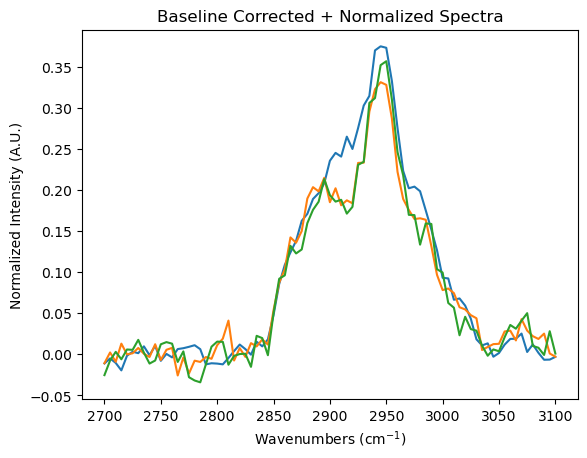

In [2]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
indeces = [random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1)]
plt.plot(wavenumbers, image_vec[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [3]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec[np.random.randint(image_vec.shape[0],size=50000)])
cluster_range = int(input('Enter range of clusters to optimize: '))
kmeans_vec.kmeans_silhoutette_score(cluster_range+1)

__________________________________________________________________________________
init		time	inertia	silhouette
Clusters: 2
PCA-based	0.990s	4870	0.451
Clusters: 3
PCA-based	0.347s	3494	0.386
Clusters: 4
PCA-based	0.488s	2931	0.318
Clusters: 5
PCA-based	0.625s	2180	0.320
Clusters: 6
PCA-based	0.865s	1922	0.278
Clusters: 7
PCA-based	0.840s	1753	0.267
Clusters: 8
PCA-based	1.156s	1643	0.226
Clusters: 9
PCA-based	1.419s	1573	0.188
Clusters: 10
PCA-based	1.798s	1375	0.193
__________________________________________________________________________________


In [4]:
## Selection of k-means number (default=7)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec)
k=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_1 = kmeans_vec.kmeans(k)

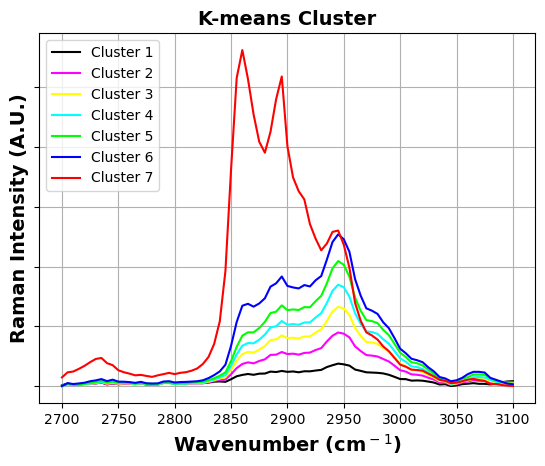

In [5]:
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
centers = kmeans_vec.kmeans_graph(kmeans_1, wavenumbers, save_input, color_list, save_dir=data.save_dir+os.sep+str(k)+'_Clusters-')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


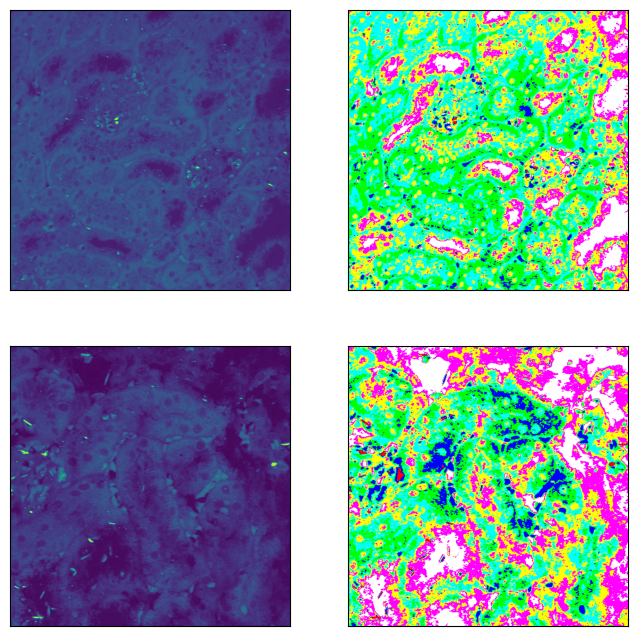

In [6]:
## Visualize Clustered Image
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
label_idx = kmeans_vec.kmeans_image(kmeans_1, max_img_list, save_input, color_list, save_dir=data.save_dir+os.sep+str(k)+'_Clusters-')


In [7]:
## Normalize Spectra
image_norm = np.zeros_like(image_vec)
max_values = np.max(image_vec[label_idx!=0],axis=1)
min_values = np.median(image_vec[label_idx!=0,:data.ch_start], axis=1)
image_norm[label_idx!=0] = processing.normalizebyvalue(image_vec[label_idx!=0], max_val=max_values, min_val=min_values, axis=1)


Text(0, 0.5, 'Normalized Intensity (A.U.)')

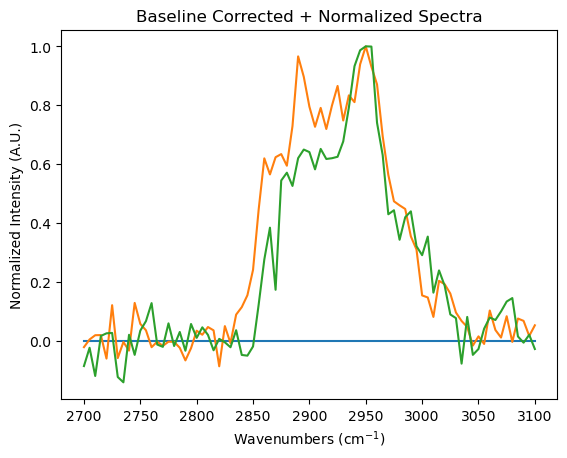

In [8]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [9]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm[np.random.randint(image_norm.shape[0],size=50000)])
cluster_range = int(input('Enter range of clusters to optimize: '))
kmeans_norm.kmeans_silhoutette_score(cluster_range+1)

__________________________________________________________________________________
init		time	inertia	silhouette
Clusters: 2
PCA-based	0.393s	15365	0.799
Clusters: 3
PCA-based	0.348s	12940	0.470
Clusters: 4
PCA-based	0.555s	11574	0.202
Clusters: 5
PCA-based	0.637s	10885	0.168
Clusters: 6
PCA-based	0.646s	10427	0.137
Clusters: 7
PCA-based	0.519s	10096	0.122
Clusters: 8
PCA-based	0.653s	9920	0.137
Clusters: 9
PCA-based	0.974s	9747	0.086
Clusters: 10
PCA-based	0.587s	9625	0.110
__________________________________________________________________________________


In [13]:
## Selection of k-means number (default=7)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm)
k_norm=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_2 = kmeans_norm.kmeans(k_norm)

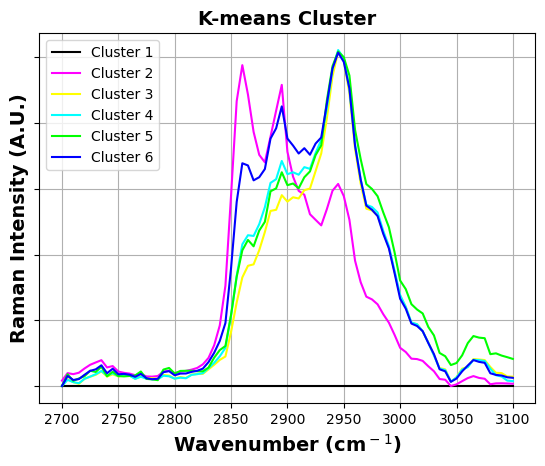

In [14]:
## Visualize Graph of Cluster Centers
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(data.wn_1, data.wn_2, data.num_samp)
_ = kmeans_norm.kmeans_graph(kmeans_2, wavenumbers, save_input, color_list, save_dir=data.save_dir+os.sep+'normalized-'+str(k_norm)+'_Clusters-')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


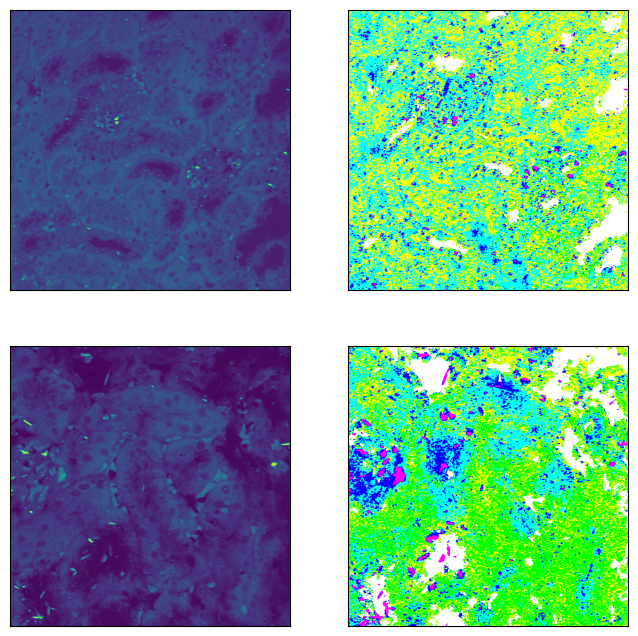

array([5., 3., 2., ..., 2., 3., 4.])

In [15]:
## Visualize Clustered Normalized Spectra
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
kmeans_norm.kmeans_image(kmeans_2, max_img_list, save_input, fig_list, save_dir=data.save_dir+os.sep+'normalized-'+str(k_norm)+'_Clusters-')